In [35]:
from Environments import *

In [37]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(50):
    action = input(f"Step number {i+1}, choose action: ")
    if action == 'q':
        break
    carenv.move(float(action))
    distance, closest_segment, closest_t = roadenv.distance_road_center(carenv.x, carenv.y)
    distance, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_segment, closest_t)
    if not  out_of_road:
        #round the direction to 2 decimal points
        print(f"   Distance: {distance:.2f}, Direction: {direction:.2f}, carenv.theta: {carenv.theta:.2f}, difection diff Direction: {abs(direction - carenv.theta):.2f}, Out of road: {out_of_road}")
        print(f" ")
    if i>2:
        plt.close('all')
        





    Visualize(roadenv, carenv, settings)

Step number 1, choose action:  .1


TypeError: list indices must be integers or slices, not dict

# Change Code

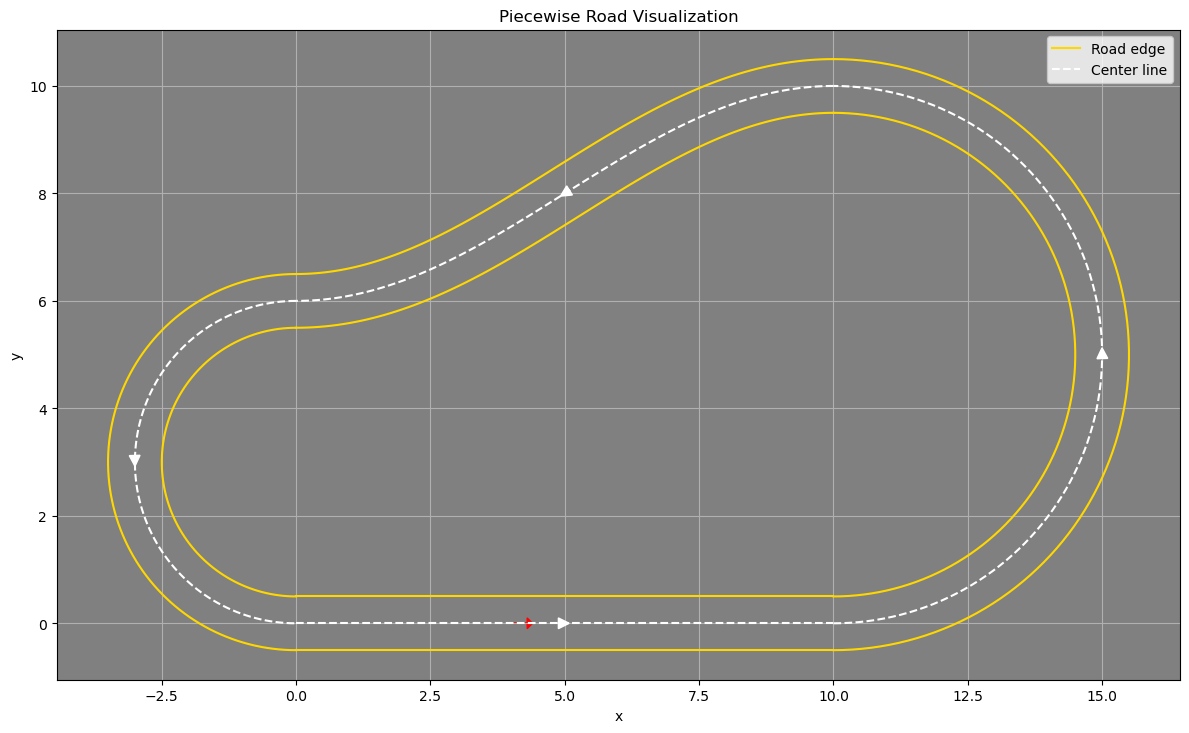

In [122]:
import math
import sympy as sp
from sympy import N
import numpy as np
from scipy.optimize import minimize_scalar

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class Settings:
    def __init__(self):
        # road settings
        self.road_segments = [
            {
                'x': lambda t: t,
                'y': lambda t: 0.000001*t,
                't_start': 0,
                't_end': 10
            },
            {
                'x': lambda t: 10 + 5 * sp.sin(np.pi * (t - 10)),
                'y': lambda t: 5-5 * sp.cos(np.pi * (t - 10)),
                't_start': 10,
                't_end': 11
            },
            {
                'x': lambda t: 21-t,
                'y': lambda t: 8 +2*sp.cos(np.pi * (t - 11)/10),
                't_start': 11,
                't_end': 21
            },
            {
                'x': lambda t: 3 * sp.sin(np.pi * (t - 20)),
                'y': lambda t: 3 - 3 * sp.cos(np.pi * (t - 20)),
                't_start': 21,
                't_end': 22
            }
        ]
        self.road_width    = 1
        self.road_length   = 15
        self.closed        = False
        self.road_resulotion = 100


        # car settings

        # car initail position
        self.init_car_x = 4
        self.init_car_y = 0
        self.init_car_theta = 0
        self.init_car_speed = .25


class RoadEnv:
    def __init__(self, settings):
        self.settings = settings
        self.t = sp.Symbol('t')

    def get_road_limits(self):
        road_limits = {'left': [], 'right': [], 'center': []}

        for segment in self.settings.road_segments:
            x = segment['x'](self.t)
            y = segment['y'](self.t)

            # Calculate the derivatives of the parametric equations
            dx_dt = sp.diff(x, self.t)
            dy_dt = sp.diff(y, self.t)

            # Calculate the normal vector
            normal_x = -dy_dt / sp.sqrt(dx_dt ** 2 + dy_dt ** 2)
            normal_y =  dx_dt / sp.sqrt(dx_dt ** 2 + dy_dt ** 2)

            # Calculate the road limits
            half_width = self.settings.road_width / 2
            left_x = x + normal_x * half_width
            left_y = y + normal_y * half_width
            right_x = x - normal_x * half_width
            right_y = y - normal_y * half_width

            # Create vectorized lambda functions for the road limits
            left_func   = sp.lambdify(self.t, [left_x, left_y], 'numpy')
            right_func  = sp.lambdify(self.t, [right_x, right_y], 'numpy')
            center_func = sp.lambdify(self.t, [x, y], 'numpy')

            road_limits['left'].append(left_func)
            road_limits['right'].append(right_func)
            road_limits['center'].append(center_func)

        return road_limits

    def distance_road_center(self, x, y):
        min_distance = float('inf')
        closest_segment = None
        closest_t = None

        for i, segment in enumerate(self.settings.road_segments):
            road_center_x = sp.lambdify(self.t, sp.sympify(segment['x'](self.t)), 'numpy')
            road_center_y = sp.lambdify(self.t, sp.sympify(segment['y'](self.t)), 'numpy')

            def distance_func(t):
                return (road_center_x(t) - x) ** 2 + (road_center_y(t) - y) ** 2

            result = minimize_scalar(distance_func, bounds=(segment['t_start'], segment['t_end']), method='bounded')
            distance = np.sqrt(result.fun)

            if distance < min_distance:
                min_distance = distance
                closest_segment = i
                closest_t = result.x

        return min_distance, closest_segment, closest_t

    def road_direction_and_terminal(self, distance, segment, t):
        if distance > self.settings.road_width / 2:
            return None, None, True

        # Calculate the direction of the road at the closest point
        segment = self.settings.road_segments[segment]
        x_func = sp.lambdify(self.t, segment['x'](self.t), 'numpy')
        y_func = sp.lambdify(self.t, segment['y'](self.t), 'numpy')

        dx_dt = sp.diff(segment['x'](self.t), self.t)
        dy_dt = sp.diff(segment['y'](self.t), self.t)
        
        dx_func = sp.lambdify(self.t, dx_dt, 'numpy')
        dy_func = sp.lambdify(self.t, dy_dt, 'numpy')

        dx = dx_func(t)
        dy = dy_func(t)
        
        direction = np.pi/2-np.arctan2(dx,dy)
        return distance, np.where(direction < 0, direction + 2 * np.pi, direction), False
    
    def reward(self, distance, road_direction, carenv_theta, out_of_road):
        if out_of_road:
            return -100
        else: 
            ang_diff1 = abs(road_direction - carenv_theta)
            ang_diff2 = min(ang_diff1,2*np.pi-ang_diff1)
            ang_diff3 = np.cos(ang_diff2)
            print(f' ang_diff1 ={ang_diff1}, ang_diff2 ={ang_diff2}, ang_diff3 ={ang_diff3}')
            return 2*(self.settings.road_width  - distance)**2 + ang_diff3

class CarEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def car_reset():
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def move(self, steering_angle):
        # Update the car position
        self.x += self.speed * np.cos(self.theta)
        self.y += self.speed * np.sin(self.theta)
        self.theta = (self.theta +steering_angle) % (2 * np.pi)
        self.trejectory.append((self.x, self.y))
        
        


def Visualize(roadenv, carenv, settings):
    road_limits = roadenv.get_road_limits()

    fig, ax = plt.subplots(figsize=(12, 12))

    for i, segment in enumerate(settings.road_segments):
        t = np.linspace(segment['t_start'], segment['t_end'], settings.road_resulotion)

        left_x, left_y = road_limits['left'][i](t)
        right_x, right_y = road_limits['right'][i](t)
        center_x, center_y = road_limits['center'][i](t)

        ax.plot(left_x, left_y, '-', color='gold')
        ax.plot(right_x, right_y, '-', color='gold')
        ax.plot(center_x, center_y, 'w--')
        
        # Add direction arrow for each segment
        mid_point = len(t) // 2
        mid_x, mid_y = center_x[mid_point], center_y[mid_point]
        dx = center_x[mid_point + 1] - center_x[mid_point]
        dy = center_y[mid_point + 1] - center_y[mid_point]
        arrow_length = 0.3
        ax.arrow(mid_x, mid_y, arrow_length * dx, arrow_length * dy,\
                 head_width=0.2, head_length=0.2, fc='white', ec='white',\
                 length_includes_head=True, zorder=3)

    ax.plot([], [], '-', color='gold', label='Road edge')
    ax.plot([], [], 'w--', label='Center line')

    ax.set_facecolor('gray')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Piecewise Road Visualization')
    ax.legend()

    # Ensure the aspect ratio is equal
    ax.set_aspect('equal', 'box')

    # Plot the car as an arrow and the trajectory in red
    arrow_length = 0.3
    ax.arrow(carenv.x, carenv.y, arrow_length*np.cos(carenv.theta), arrow_length*np.sin(carenv.theta),
             head_width=0.2, head_length=0.1, fc='r', ec='r', label='Car')
    ax.plot(*zip(*carenv.trejectory), 'r--', label='Trajectory')

    ax.grid(True)
    plt.tight_layout()
    plt.show()




settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)


Visualize(roadenv, carenv, settings)
# # move the car
# for i in range(50):
#     Visualize(roadenv, carenv, settings)
#     action = input(f"Step number {i+1}, choose action: ")
#     if action == 'q':
#         break
#     carenv.move(float(action))
#     distance, closest_segment, closest_t = roadenv.distance_road_center(carenv.x, carenv.y)
#     distance, road_direction, out_of_road = roadenv.road_direction_and_terminal(distance, closest_segment, closest_t)
#     reward = roadenv.reward(distance, road_direction, carenv.theta, out_of_road)
    
#     if not  out_of_road:
#         #round the direction to 2 decimal points
#         print(f"   Distance: {distance:.2f}, Direction: {road_direction:.2f}, carenv.theta: {carenv.theta:.2f}, difection diff Direction: {abs(road_direction - carenv.theta):.2f}, Out of road: {out_of_road}")
#         print(f"    reward = {reward} ")
#         print(f" ")
#     if i>2:
#         plt.close('all')
        


In [67]:
for i in np.linspace(0,2*np.pi,10):
    print(f'i = {i}, sin = {np.sin(i)}, cos = {np.cos(i)}') 

i = 0.0, sin = 0.0, cos = 1.0
i = 0.6981317007977318, sin = 0.6427876096865393, cos = 0.766044443118978
i = 1.3962634015954636, sin = 0.984807753012208, cos = 0.17364817766693041
i = 2.0943951023931953, sin = 0.8660254037844387, cos = -0.49999999999999983
i = 2.792526803190927, sin = 0.3420201433256689, cos = -0.9396926207859083
i = 3.490658503988659, sin = -0.34202014332566866, cos = -0.9396926207859084
i = 4.1887902047863905, sin = -0.8660254037844384, cos = -0.5000000000000004
i = 4.886921905584122, sin = -0.9848077530122081, cos = 0.17364817766692997
i = 5.585053606381854, sin = -0.6427876096865396, cos = 0.7660444431189778
i = 6.283185307179586, sin = -2.4492935982947064e-16, cos = 1.0
